## Imports

In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from numpy.linalg import matrix_rank

## Funciones de la práctica anterior

Declaramos aquellas funciones de la práctica anterior que van a ser utilizadas.

In [2]:
def BGRtoRGB(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [3]:
def isBW(im):
    return len(im.shape) == 2

In [4]:
def normalize(im):
    max_val = np.amax(im)
    min_val = np.amin(im)
    im = (im - min_val) / (max_val - min_val)
    return im

In [5]:
def leeimagen(filename, flagColor):
    if flagColor == 1:
        return BGRtoRGB(cv2.imread(filename, flagColor)).astype("float32")
    return cv2.imread(filename, flagColor).astype("float32")

In [6]:
def pintaI(im, titulo="Imagen", norm = True):
    
    if (norm):
        img = normalize(im)
    else:
        img = im
        
    plt.axis("off")
    plt.title(titulo)
    plt.rcParams['figure.figsize'] = [15, 15]   
    
    if isBW(im):
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.show()

In [7]:
def hstack(vim, border=(1,1,1), norm = True):

    altura = max(im.shape[0] for im in vim)

    for i,im in enumerate(vim):

        if(norm):
            vim[i] = normalize(im)
        
        if isBW(im):
            vim[i] = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

        if im.shape[0] < altura:
            vim[i] = cv2.copyMakeBorder(
                vim[i], 0, altura - vim[i].shape[0],
                0, 0, cv2.BORDER_CONSTANT, value = border
            )      
   

    return np.hstack(vim)


In [199]:
def pintaMI(vim, titulo='Imagenes', border=(1,1,1), norm = True):
    pintaI(hstack(vim, border, norm), titulo, norm)

In [129]:
def vstack(vim, border=(1,1,1), norm = True):

    anchura = max(im.shape[1] for im in vim)

    for i,im in enumerate(vim):

        if(norm):
            vim[i] = normalize(im)
        
        if isBW(im):
            vim[i] = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

        if im.shape[1] < anchura:
            vim[i] = cv2.copyMakeBorder(
                vim[i], 0, 0,
                0, anchura - vim[i].shape[1], cv2.BORDER_CONSTANT, value = border
            )  
    return np.vstack(vim)


In [10]:
def representaIm(vim, titulos, norm = True):
    pintaMI(vim, titulo = " | ".join(titulos), norm = norm)

## Ejercicios

### Función convolución

Definimos una función que nos permitirá añadir un borde de tamaño ```tam``` a una imagen monobanda de 3 formas distintas:
+ **tipo = 0.** Se creará un borde constante de valor ```value```. Por defecto ```0```.
+ **tipo = 1.** Se creará un borde reflejando la parte final de la imagen.
    Por ejemplo, la imagen ```abc```, resultaría en ```cba|abc|cba```
+ **tipo = 2.** Se creará un borde replicando la parte final de la imagen.
    Por ejemplo, lla imagen ```abc```, resultaría ```aaa|abc|ccc```

In [11]:
def make_border(img, tamx, tamy=0, tipo = 2, value = 0):
    
    if tamy == 0:
        tamy = tamx
    
    ret = np.zeros([img.shape[0]+2*tamy, img.shape[1]+2*tamx])
    
    if tipo == 0:
        ret = ret+value
        ret[tamy:-tamy,tamx:-tamx] = img
    
    if tipo == 1:
        ret[tamy:-tamy,tamx:-tamx] = img
        for i in range(0, tamy):
            ret[i][tamx:-tamx] = img[tamy-i]
        for i in range(0, tamx):
            ret.T[i][tamy:-tamy] = img.T[tamx-i]
        for i in range(-tamy, 0):
            ret[i][tamx:-tamx] = img[-tamy-i-1]
        for i in range(-tamx, 0):
            ret.T[i][tamy:-tamy] = img.T[-tamx-i-1]
            
    if tipo == 2:
        ret[tamy:-tamy,tamx:-tamx] = img
        for i in range(0, tamy):
            ret[i][tamx:-tamx] = img[0]
        for i in range(0, tamy):
            ret.T[i][tamy:-tamy] = img.T[0]
        for i in range(-tamy, 0):
            ret[i][tamx:-tamx] = img[-1]
        for i in range(-tamy, 0):
            ret.T[i][tamy:-tamy] = img.T[-1]

    return ret.astype("float32")
     

Probamos los bordes en una imagen de muestra. 
+ En la primera imagen pordemos observar como se ha creado un borde oscuro alrededor del figura.
+ En la segunda imagen se puede observar como se crea un reflejo de la figura en el borde.
+ En la tercera imagen vemos como llegados al borde los pixeles se extienden de forma continua.

En todos los modos dejamos las esquinas sin alterar ya que estas no entran en el cálculo de la convolución.

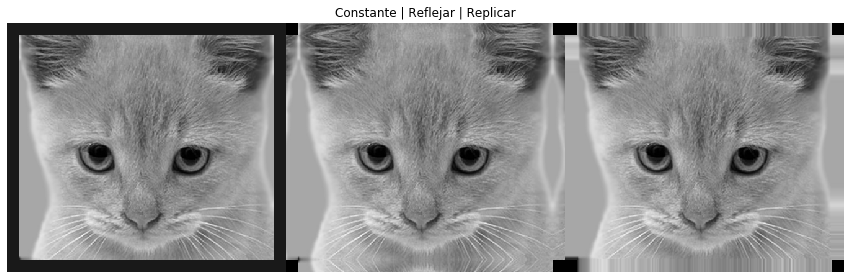

In [277]:
representaIm(
    [make_border(normalize(leeimagen("images/cat.png", 0)), 20, tipo = 0, value = 0.1),
    make_border(normalize(leeimagen("images/cat.png", 0)), 20, tipo = 1),
    make_border(normalize(leeimagen("images/cat.png", 0)), 20)],
    ["Constante", "Reflejar", "Replicar"])  

Declaramos la función que calculará la convolución de una imagen monobanda. Para ello necesitamos los siguientes pámetros:
- ```img```. La imagen sobre la que aplicar la convolución.
- ```vx```. El vector de convolución en el eje ```x```.
- ```vy```. El vector de convolución en el eje ```y```.

información sobre la convolución de numpy: [Info](https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html)

Es necesario hacer un cast a ```f32``` sobre todos los elementos de la matriz si queremos utilizar ```cv2.cvtColor``` y mostrar las imagenes juntas, ya que dicha función no acepta matrices de mayor precisión.

In [13]:
def convolucion2D_monobanda(img, vx, vy, border_type = 2, value = 0):
    nrows = img.shape[0]
    ncols = img.shape[1]
    
    kx = len(vx) // 2
    ky = len(vy) // 2
    img_res = make_border(img, kx, ky, border_type, value)
    
    for i in range(0, nrows + 2 * ky):
        img_res[i] = np.convolve(img_res[i], vx, 'same')

    for j in range(0, ncols + 2 * kx):
        img_res[:,j] = np.convolve(img_res[:,j], vy, 'same')

    return img_res[ky:-ky, kx:-kx].astype("float32")

Declaramos ahora una función que nos permitirá hacer la convolución de una imagen a color, ya que llamará a la anterior sobre cada una de las dimensiones.

In [14]:
def convolucion2D(img, vx, vy, border_type = 2, value = 0):
    
    if isBW(img):
        return convolucion2D_monobanda(img, vx, vy, border_type, value)
    
    aux = np.copy(img)
    for dimension in range(img.shape[2]):
        aux[:,:,dimension] = convolucion2D_monobanda(img[:,:,dimension],vx,vy, border_type, value)
        
    return aux

Probamos ahora la convolución 2D que hemos implementado.

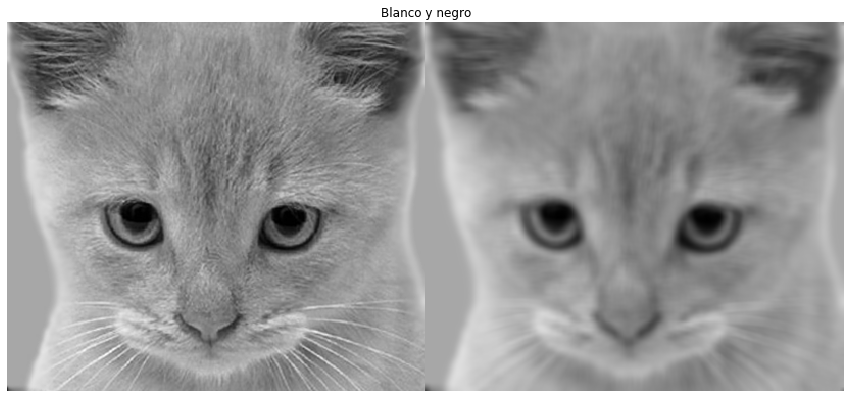

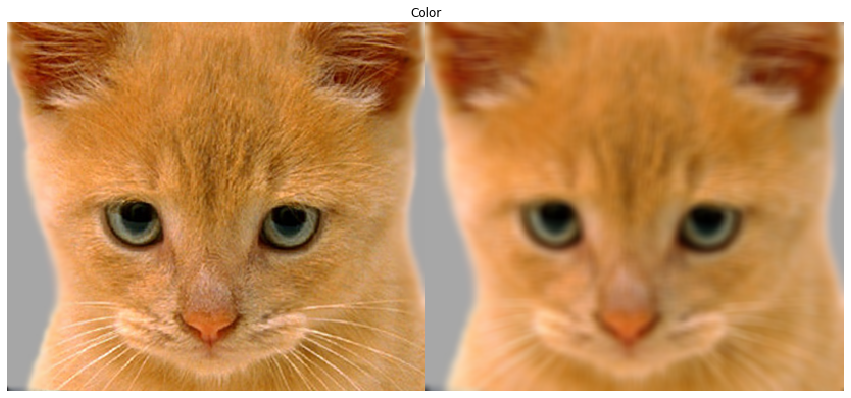

In [15]:
blur = [1.0/9 for i in range(9)]
im1 = normalize(leeimagen("images/cat.png", 0))
im2 = convolucion2D(im1, blur, blur)
im = normalize(leeimagen("images/cat.png", 1))
im3 = convolucion2D(im, blur, blur)
pintaMI([im1, im2], titulo="Blanco y negro")
pintaMI([im,im3], "Color")

In [16]:
def convolucion2D_m(img, k, border_type = 2, value = (0,0,0)):
    if (matrix_rank(k) == 1):
        u = k[0]
        v = k.T[0]
        
        for i in range(0, k.shape[0]):
            if (np.count_nonzero(k[i]) != 0):
                u = k[i]
                break
        
        for i in range(0, k.shape[1]):
            if (np.count_nonzero(k.T[i]) != 0):
                v = k.T[i]
                break
        
        u = np.matrix(u).T
        v = np.matrix(v)
        u = u*np.amax(k/(u@v))
        u = np.squeeze(np.asarray(u))
        v = np.squeeze(np.asarray(v))

        return convolucion2D(img, u, v, border_type, value)
    
    return img

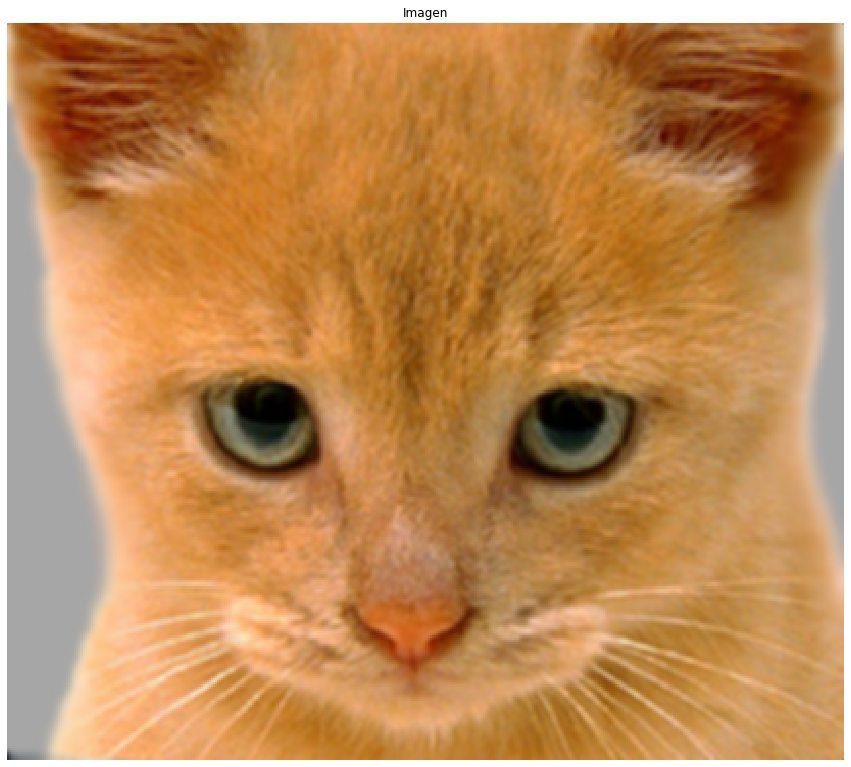

In [17]:
N=3
M=3
a = np.empty((N,M))
a[:] = 1/(N*M)
im2 = convolucion2D_m(im, a)
pintaI(im2)

## Ejercicio 1

### Gaussiana

Declaramos la función Gaussiana, no es necesario añadir el denominador al cálculo ya que dado un sigma es una constante y el kernel va a ser posteriormente normalizado.

In [18]:
def gaussian(x, sig):
    return np.exp(-np.power(x, 2.) / (2 * np.power(sig, 2.)))

Definimos la función que calculará la Gaussiana de ```img```. Los pasos son los siguientes:
+ Aceptamos dos valores de $\sigma$, en caso de ser el segundo nulo lo igualamos al primero.
+ Generamos aquellos números enteros entre $-3\sigma_x$ y $3\sigma_x$ y calculamos el vector de sus imagenes por la función gausiana.
+ Hacemos lo mismo para $\sigma_y$
+ Normalizamos ambos vectores.
+ Hacemos la convolución de la imagen con ambos vectores.

In [19]:
def gaussiana(img, sx, sy=0, tamx = 0, tamy = 0):
    
    if sy == 0:
        sy = sx
    
    vx = []
    vy = []
    
    x_bound = tamx
    y_bound = tamy
    if (x_bound == 0):
        x_bound = int(3*sx)
    
    if (y_bound == 0):
        y_bound = int(3*sy)
    
    for i in range(-x_bound, x_bound):
        vx.append(gaussian(i,sx))
        
    for i in range(-y_bound, y_bound):
        vy.append(gaussian(i,sy))
        
    vx = vx/np.linalg.norm(vx)
    vy = vy/np.linalg.norm(vy)
            
    return convolucion2D(img, vx, vy)

Probamos la función para distintos valores de $\sigma$.

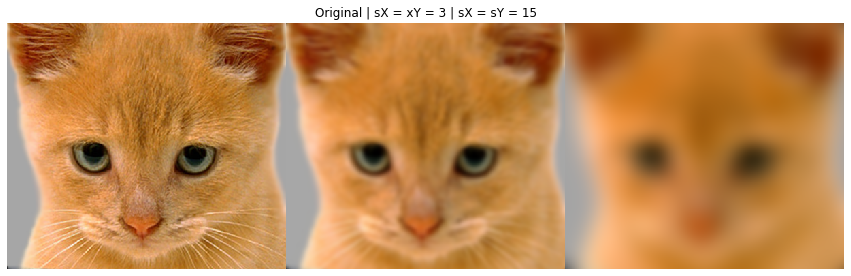

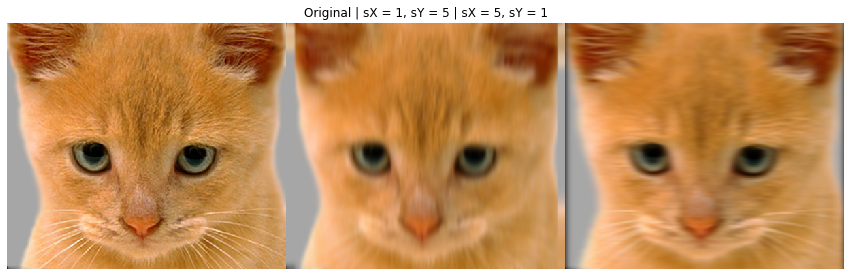

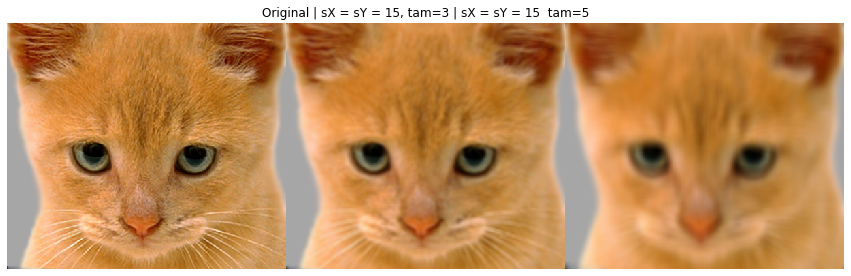

In [20]:
im = normalize(leeimagen("images/cat.png", 1))
representaIm([im, gaussiana(im, 3), gaussiana(im, 15)], ["Original", "sX = xY = 3","sX = sY = 15"])
representaIm([im, gaussiana(im, 1, 5), gaussiana(im, 5, 1)], ["Original", "sX = 1, sY = 5", "sX = 5, sY = 1"])
representaIm([im, gaussiana(im, 15, 15, 3, 3), gaussiana(im,15 , 15, 5, 9)], ["Original", "sX = sY = 15, tam=3", "sX = sY = 15  tam=5"])

Podemos observar lo siguiente:
+ A mayor valor de $\sigma$, mayor difuminación se produce en la imagen.
+ También podemos observar como si $\sigma_X \neq \sigma_Y$, entonces se produce cierta deformación en el sentido del mayor de ellos. 
+ Tambien se puede observar que si el tamaño del kernel es demasiado pequeño, el efecto del filtro se ve reducido.

### Derivadas

Declaramos la funcion que obtiene máscaras 1D de máscaras derivadas realizando una llamada a ```getDerivKernels```. Los parámetros son:
- ```dx```: orden de derivación respecto de ```x```.
- ```dy```: orden de derivación respecto de ```y```.
- ```tam```: tamaño del kernel.

Le indicamos a la función que queremos que los resultados se encuentren normalizados.

In [21]:
def derivadas(dx, dy, tam):
    return cv2.getDerivKernels(dx,dy,tam, normalize=True)

Mostramos los resultados utilizando derivadas de segundo orden con tamaño 3 y 5.

In [22]:
ders = [(0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
tams = [3, 5]

for tam in tams:
    print("Tamaño = {}".format(tam))
    for dx, dy in ders:
        print("  ({}, {})".format(dx, dy), end = ": ")
        print("{}, {}".format(*map(np.transpose, derivadas(dx, dy, tam) )))

Tamaño = 3
  (0, 1): [[0.25 0.5  0.25]], [[-0.5  0.   0.5]]
  (0, 2): [[0.25 0.5  0.25]], [[ 1. -2.  1.]]
  (1, 0): [[-0.5  0.   0.5]], [[0.25 0.5  0.25]]
  (1, 1): [[-0.5  0.   0.5]], [[-0.5  0.   0.5]]
  (1, 2): [[-0.5  0.   0.5]], [[ 1. -2.  1.]]
  (2, 0): [[ 1. -2.  1.]], [[0.25 0.5  0.25]]
  (2, 1): [[ 1. -2.  1.]], [[-0.5  0.   0.5]]
  (2, 2): [[ 1. -2.  1.]], [[ 1. -2.  1.]]
Tamaño = 5
  (0, 1): [[0.0625 0.25   0.375  0.25   0.0625]], [[-0.125 -0.25   0.     0.25   0.125]]
  (0, 2): [[0.0625 0.25   0.375  0.25   0.0625]], [[ 0.25  0.   -0.5   0.    0.25]]
  (1, 0): [[-0.125 -0.25   0.     0.25   0.125]], [[0.0625 0.25   0.375  0.25   0.0625]]
  (1, 1): [[-0.125 -0.25   0.     0.25   0.125]], [[-0.125 -0.25   0.     0.25   0.125]]
  (1, 2): [[-0.125 -0.25   0.     0.25   0.125]], [[ 0.25  0.   -0.5   0.    0.25]]
  (2, 0): [[ 0.25  0.   -0.5   0.    0.25]], [[0.0625 0.25   0.375  0.25   0.0625]]
  (2, 1): [[ 0.25  0.   -0.5   0.    0.25]], [[-0.125 -0.25   0.     0.25   0.125]]
 

Probamos a aplicar 3 de ellas a una imagen. En lo resultados podemos apreciar como las derivadas respecto a ```Y``` resaltan  aquellas partes de la imagen que cambian de forma horizontal, en caso de aumentar el grado de la derivada, los cambios deben ser mas acentuados para resaltar. En caso de las derivadas respecto a ```X```, ocurre lo mismo en el eje vertical.

Declaramos una función auxiliar para hacer el valor absoluto y normalizar una imagen, de forma que tambien resaltamos los mínimos resultantes.

In [23]:
def norm_abs(im):
    return normalize(abs(im))

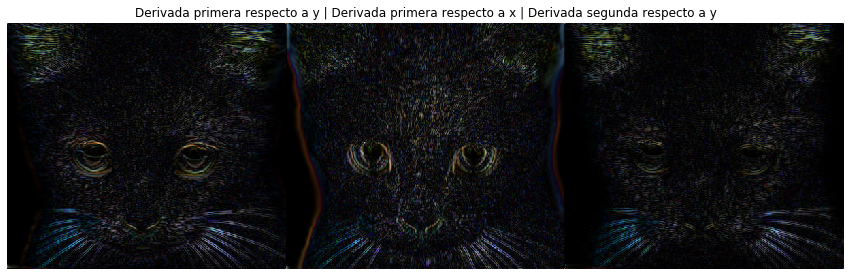

In [24]:
representaIm( [norm_abs(convolucion2D(im, [0.25, 0.5, 0.25 ],[-0.5,0,0.5])), 
               norm_abs(convolucion2D(im, [-0.5,0,0.5 ],[0.25,0.5,0.25])),
               norm_abs(convolucion2D(im, [0.0625, 0.25, 0.375, 0.25, 0.0625], [0.25,  0, -0.5,  0,  0.25]))],
             ["Derivada primera respecto a y", "Derivada primera respecto a x", "Derivada segunda respecto a y"])

### Laplaciano

Utilizamos la función Laplacian para el cálculo de la convolución 2D con una máscara normalizada de Laplaciana-de-Gaussiana de tamaño variable.
Argumentos:
+ ```im```: Imagen a la que aplicar la máscara.
+ ```tam```: Tamaño de la máscara.
+ ```tipoBorde```: Tipo de borde.
Nos devuelve la imagen con la máscara aplicada.

Aplicamos Gaussian Blur a la imagen. 
Aplicamos el operador Laplaciano con un tipo mayor.

https://theailearner.com/tag/cv2-laplacian/

In [316]:
def laplaciano(im, s, tam = 0, border = 2, value = 0):
    g = gaussiana(im, s)
    d = derivadas(2, 0, 5)
    g1 = convolucion2D(g, d[0].T[0], d[1].T[0], border_type = border, value = value)
    g2 = convolucion2D(g, d[1].T[0], d[0].T[0], border_type = border, value = value)
    return abs(s*s*(g1+g2))

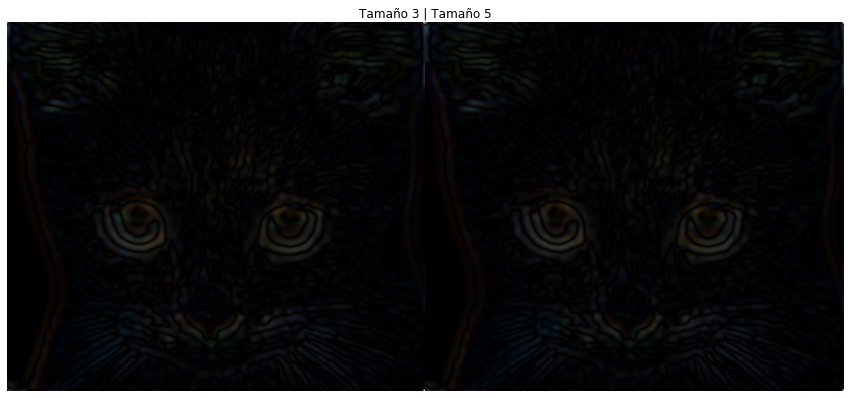

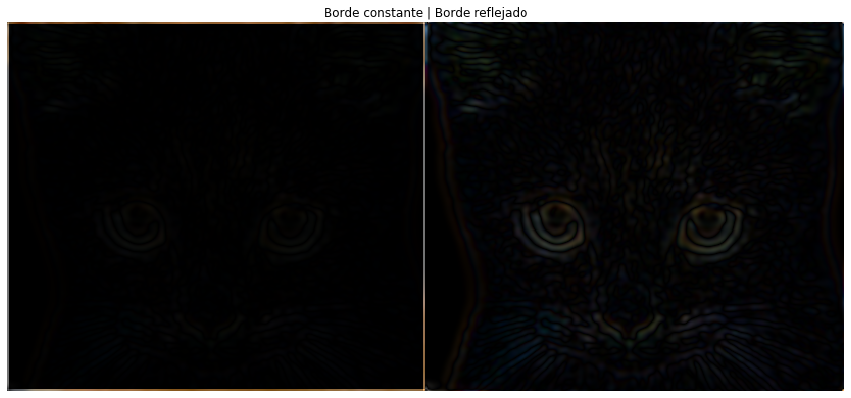

In [317]:
representaIm([laplaciano(im, 3, 3), laplaciano(im, 3, 5)], 
             ["Tamaño 3"] + ["Tamaño 5"])

representaIm([laplaciano(im, 3, 3, 0), laplaciano(im, 3, 3, 1)], 
             ["Borde constante"] + ["Borde reflejado"])

## Ejercicio 2

Añado una imagen mia de tamaño 512x512 para facilitar los upsample y downsample.

In [278]:
im = normalize(leeimagen("images/cat.png", 1))


In [249]:
def blur_and_downsample(img, s):
    if isBW(img):
        return normalize(gaussiana(img,s)[::2,::2])
    return normalize(gaussiana(img, s)[::2,::2,:])

def blur_and_upsample(img, s):
    return normalize(gaussiana(img.repeat(2, axis=0).repeat(2, axis=1),s))

In [250]:
def piramide_gaussiana(img, s = 1):
    
    res1 = normalize(blur_and_downsample(img, s))
    res2 = normalize(blur_and_downsample(res1, s))
    res3 = normalize(blur_and_downsample(res2, s))
    res4 = normalize(blur_and_downsample(res3, s))

    return (hstack([img, vstack([res1, res2, res3, res4])]), img, res1, res2, res3, res4)

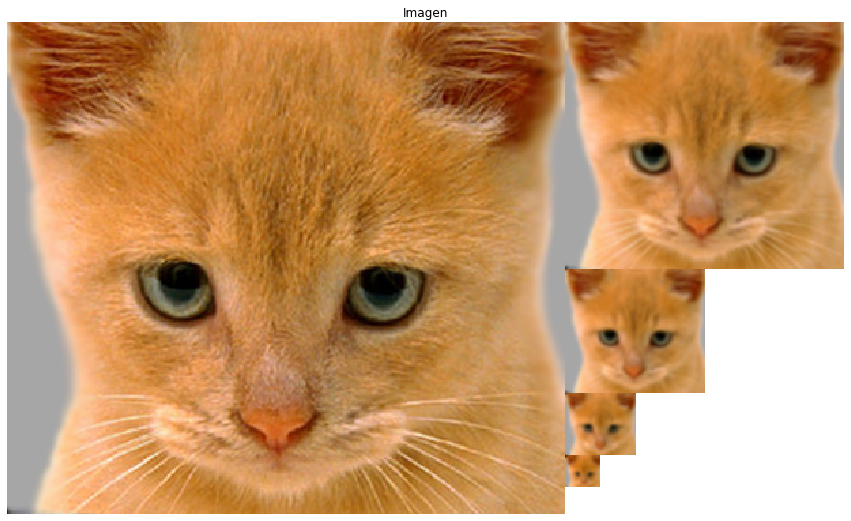

In [300]:
pintaI(piramide_gaussiana(im, 2)[0], norm = False)

In [298]:
def piramide_laplaciana(img, s=1):  
    
    d1 = blur_and_downsample(img, s)
    u1 = blur_and_upsample(d1, s)
    u1 = cv2.resize(u1, (img.shape[1], img.shape[0]))
    l1 = img - u1
    
    d2 = blur_and_downsample(d1, s)
    u2 = blur_and_upsample(d2, s)
    u2 = cv2.resize(u2, (d1.shape[1], d1.shape[0]))
    l2 = d1 - u2
    
    d3 = blur_and_downsample(d2, s)
    u3 = blur_and_upsample(d3, s)
    u3 = cv2.resize(u3, (d2.shape[1], d2.shape[0]))
    l3 = d2 - u3
    
    d4 = blur_and_downsample(d3, s)
    u4 = blur_and_upsample(d4, s)
    u4 = cv2.resize(u4, (d3.shape[1], d3.shape[0]))
    l4 = d3 - u4
    
    d5 = blur_and_downsample(d4, s)
    u5 = blur_and_upsample(d5, s)
    u5 = cv2.resize(u5, (d4.shape[1], d4.shape[0]))
    l5 = d4 - u5

    return (hstack([l1, vstack([l2, l3, l4, l5])]), l1, l2, l3, l4, l5 )

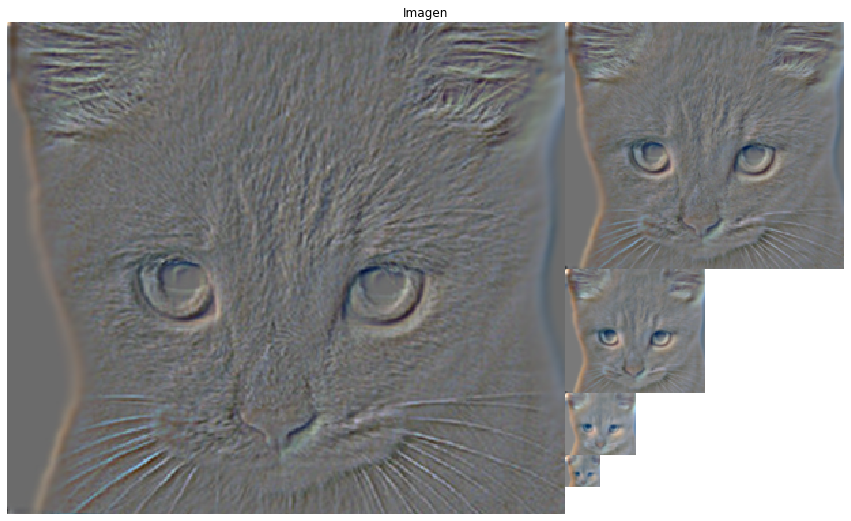

In [303]:
pintaI(piramide_laplaciana(im)[0])

In [254]:
def reconstruct_original(l1, l2, l3, l4, x4):
    u1 = blur_and_upsample(x4, 1)
    u1 = cv2.resize(u1, (l4.shape[1], l4.shape[0]))
    aux = l4 + u1
    
    u2 = blur_and_upsample(aux, 1)
    u2 = cv2.resize(u2, (l3.shape[1], l3.shape[0]))
    aux = l3 + u2
    
    u3 = blur_and_upsample(aux, 1)
    u3 = cv2.resize(u3, (l2.shape[1], l2.shape[0]))
    aux = l2 + u3
    
    u4 = blur_and_upsample(aux, 1)
    u4 = cv2.resize(u4, (l1.shape[1], l1.shape[0]))
    aux = l1 + u4
    
    return normalize(aux)

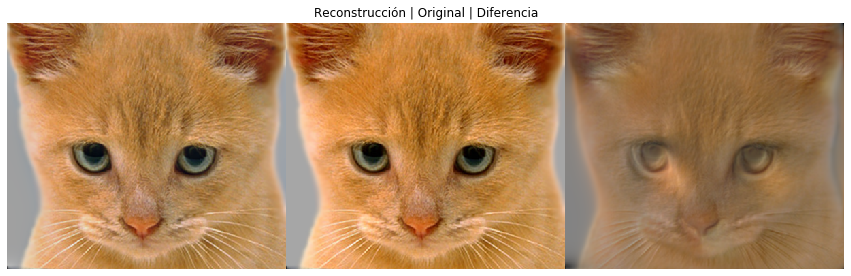

In [302]:
g = piramide_gaussiana(im, 2)
l = piramide_laplaciana(im, 2)

pintaMI([reconstruct_original(l[1], l[2], l[3], l[4], g[5]), im, im - reconstruct_original(l[1], l[2], l[3], l[4], g[5]) ], "Reconstrucción | Original | Diferencia")

In [35]:
def escalas(img, n, s):
    a = laplaciano(img, s)
    pintaI(a)

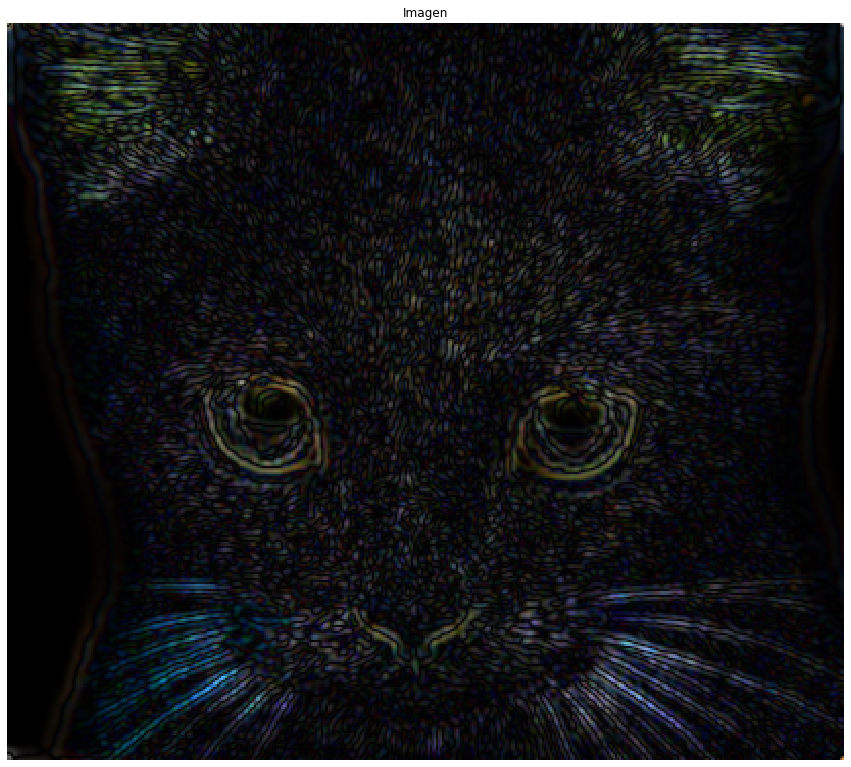

In [36]:
escalas(im, 1, 1)

In [266]:
def hibrid(im1, im2, s1, s2):
    low = normalize(gaussiana(im1, s1))
    high = im2 - normalize(gaussiana(im2, s2))
    return low+high

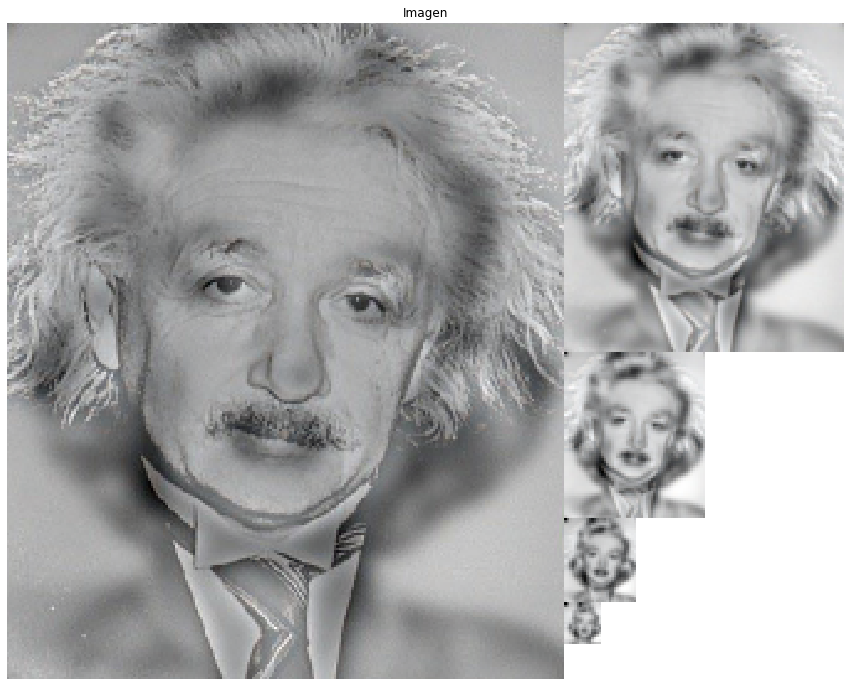

In [267]:
marilyn = normalize(leeimagen("images/marilyn.png", 1))
einstein = normalize(leeimagen("images/einstein.png", 1))
pintaI(piramide_gaussiana(hibrid(marilyn, einstein, 4,4))[0])

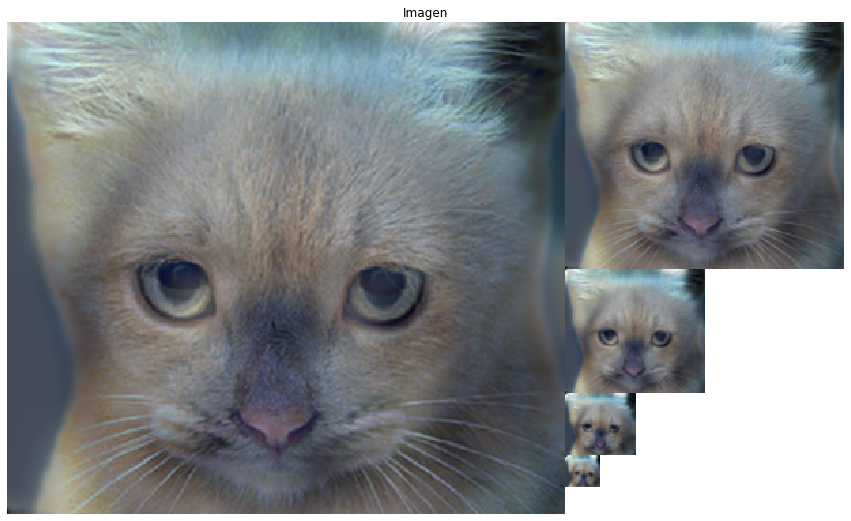

In [270]:
cat = normalize(leeimagen("images/cat.png", 1))
dog = normalize(leeimagen("images/dog.png", 1))
pintaI(piramide_gaussiana(hibrid(dog,cat, 9,9))[0])

In [275]:
y = normalize(leeimagen("images/yo.jpg", 1))
d = normalize(leeimagen("images/dreji.jpg", 1))

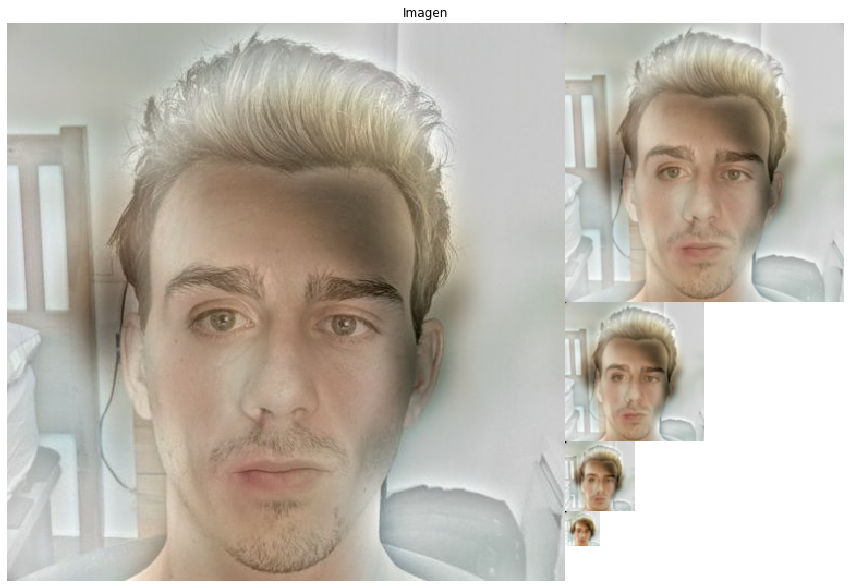

In [276]:
pintaI(piramide_gaussiana(hibrid(d,y, 12,12))[0])